## Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Dataset Loading

### Load Dataset

In [2]:
df_train = pd.read_csv('train.csv')

### Dataset Overview

In [3]:
df_train.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

- The dataset consists of 45,593 delivery records with 20 columns, encompassing a mix of data types including int64, float64, and object.<br>
- The output variable in the dataset is Time_taken(min), which represents the delivery time in minutes.

In [5]:
# Summary Statistics for numerical columns
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [6]:
# Summary Statistics for non-numerical columns
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


#### Key Observations
- The Time_Ordered column contains NaN values that require handling.
- We need to explore other columns for potential null values.
- The Time_taken(min) column should be converted to a numerical value instead of an object.
- We need to address the object datatypes in the dataset.
- Data and tiem features also require handling and preprocessing.

## Data Cleaning
Now that we have a basic understanding of the dataset, let's proceed with data cleaning. Data cleanins is a crucial process involving the identification and rectification of errors, inconsistencies, and missing values within a dataset.<br>
During the step, we will focus on formatting column anmes, adjusting column values, updating data types, droppiing unnecessary columns, handling missing values, and checking for any duplicate data. By addressing these aspects, we can enhance the overall quality and reliability of the dataset.<br><br>
### Format Column Names
Let's start by formatting the column names, as it will enhance the clarity and readability of the data.

In [7]:
# Change name Weatherconditions to Weather_conditions
df_train.rename(columns={'Weatherconditions':'Weather_conditions'}, inplace=True)

### Data Extraction
Next, we will proceed with extracting values from certain features. This step will enable us to retrieve specific and relevant information from the dataset, aligning with our nalysis and modeling objectives.<br>
For instance, by extracting the city name form the "Delivery_person_ID" column, we can obtain a valuable variable that will ais us in the development of our model. Additionally, clarity can be achieved by removing the "conditions" from the "Weather_conditions" column and eliminating the "(min)" form the "Time_taken" column. These adjustments will improve the overall clarity and understanding of the data.

In [8]:
def extract_column_value(df):
    # Extract time and convert to int
    df['Time_taken(min)']=df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    # Extract Weather conditions
    df['Weather_conditions']=df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    # Extract city code from Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]

In [9]:
extract_column_value(df_train)
df_train[['Time_taken(min)', 'Weather_conditions', 'City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


### Update Data Types
Next, we will proceed to update the data types of features to their most appropriate formats.

In [10]:
# Update datatypes

def update_datatype(df):
    # Update datatype from object to float
    df['Delivery_person_Age']=df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries']=df['multiple_deliveries'].astype('float64')
    # Update datatype from object to datetime
    df['Order_Date']=pd.to_datetime(df['Order_Date'], format="%d-%m-%Y")

In [11]:
update_datatype(df_train)

### Drop Colummns
We can eliminate ID and Delivery_person_ID columns since they solely serve as unique identifiers and do not provide any valuable information for our analysis or model building pruposes. Removing these columns will help streamline the data and improve the clarity and efficiency of our analysis.

In [12]:
df_train.drop(['ID', 'Delivery_person_ID'], axis=1, inplace=True)

### Check for Duplicate Values
Let's check for any duplicate values in the dataset to ensure data accuracy and eliminate bias. If duplicates are found, we will need to remove them to maintain the integrity of the data.

In [13]:
# Check for Duplicate Values
if(len(df_train[df_train.duplicated()])>0):
    print("There are Duplicate values present.")
else:
    print("There is NO Duplicate values present.")

There is NO Duplicate values present.


Since there are no duplicate values present, we can proceed to the next step and address the missing values in teh dataset.

### Handle Missing Values
Handling missing values is crucial for preserving data integrity, ensuring accurate analyses, and preventing biased results or incomplete insights. As part of this process, we will convert NaN strings to np.nan and then calculate and print the count of missing values for each feature.

In [14]:
# Replace NaN to np.nan
df_train.replace('NaN', float(np.nan), regex=True, inplace=True)
# Show count of NaN values in data
df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

Given the presence of NaN values in multiple columns, visualizing these columns qould be beneficial for identifying patterns and determining the optimal approach to handle null values for each feature.

## Data Visualization

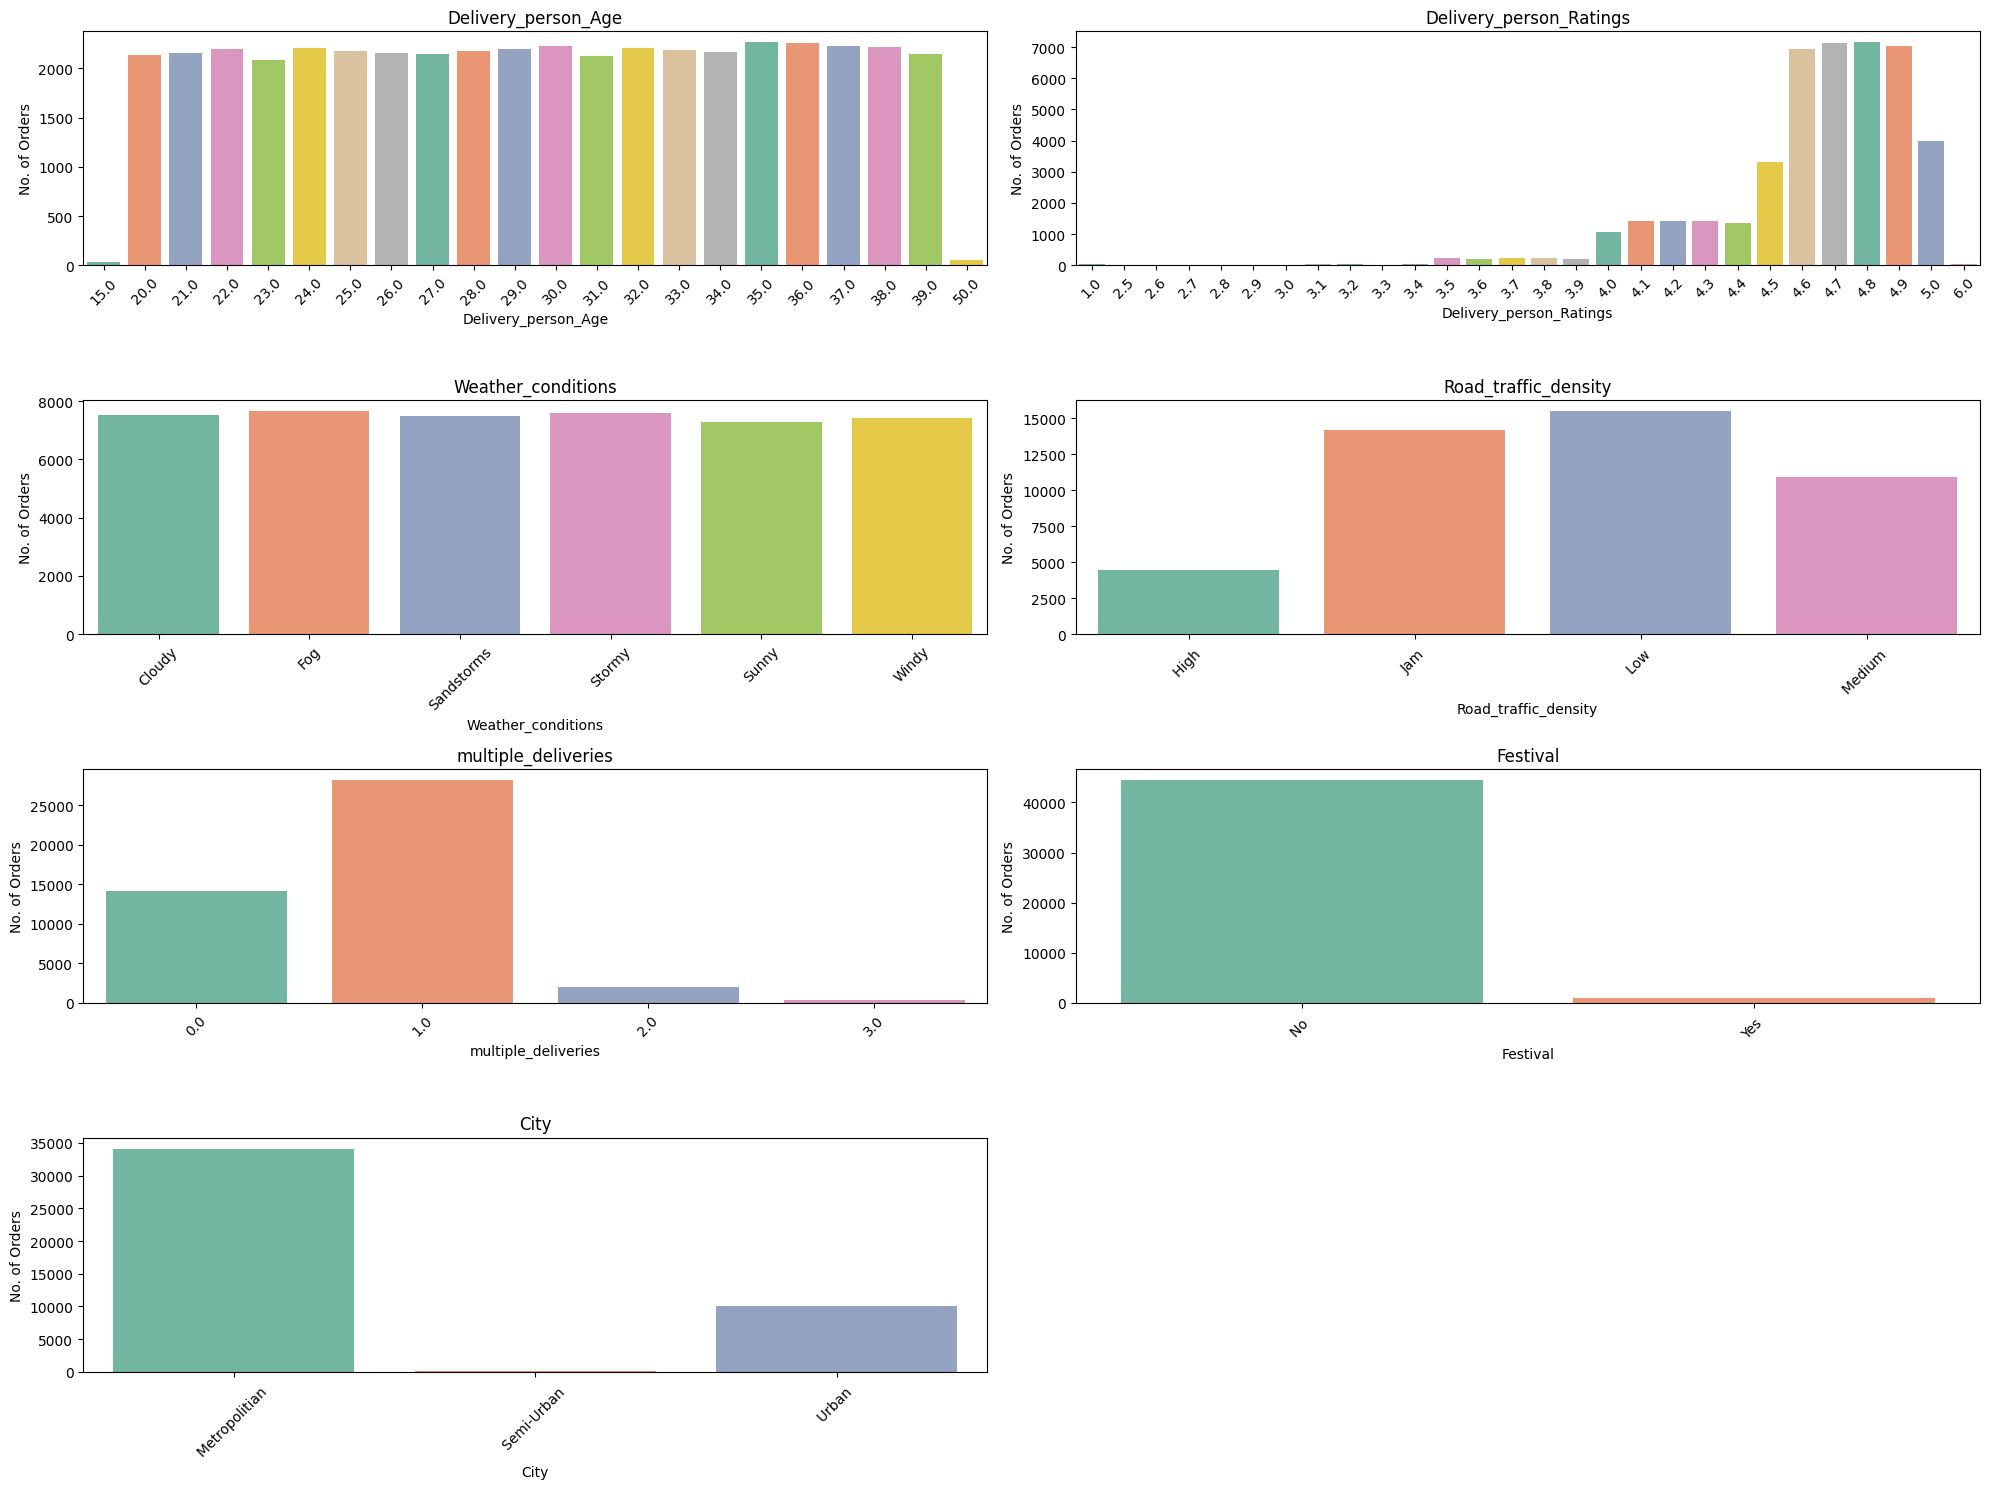

In [15]:
cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Weather_conditions', 
        'Road_traffic_density', 'multiple_deliveries', 'Festival', 'City']
num_plots = len(cols)
num_rows = (num_plots//2)+(num_plots%2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20, 15))

for i, column_name in enumerate(cols):
    row=i//2
    col=i%2
    
    ax=axes[row, col]
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax, palette='Set2')
    
    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)

if num_plots%2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

- For Delivery_person_Age and Weather_conditions, which display neraly uniform distributions, the missing values will be filled randomly.
- As for Delivey_person_Ratings, which exhibits a left-skewed distributions, the missing values will be filled with the median.
- For the remaining categorical columns, the missing values will be filled with the mode, representing the most frequently occuring value in each respective column.<br><br>
These approaches will help ensure that missing values are appropriately handled based on the characteristics of each column.

In [16]:
# Handle null values
def handle_null_values(df):
    df_train['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df_train['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df_train['City'].fillna(df['City'].mode()[0], inplace=True)
    df_train['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df_train['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df_train['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df_train['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

In [17]:
handle_null_values(df_train)
df_train.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

NOTE --> At present, we have not addressed the NaN values in the Time_Ordered column. However, we will handle them in the next section adter converting the column to a datetime object. This sequential approach allows us to ensure accurate handling of missing values once the necessary data transformation is completed.

## Feature Engineering
Now let's proceed to the next step of Feature Engineering. In this step, we carefully select, transform, and generate meaningful features from the data, aiming to enhance the preformance of our ML models. This process offers various benefits, including imporved model accuracy, mitigated overfitting, and the discovery of hidden patterns.<br><br>
In this specific scenario, we have access to features like order date, order time, and picked time, which provide ample opportunities for creating multiple new features than can help us in capturing and utilizing various aspect of time-related information.<br><br>
Furthermore, we have latitude and longitude features for both the restaurant and delivery location. Leveraging this information, we can calculate the distance between the two locations, adding yet another valubale feature to our dataset.<br><br><br>
Let's begin by generating new features based on the Order Date.

In [18]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data["day_of_week"] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data["is_weekend"] = np.where(data['day_of_week'].isin([5, 6]), 1, 0)

In [19]:
extract_date_features(df_train)

Next, we'll create a new feature that highlights the difference between the order time and the pickup time. As part of this step, we will drop all the time and date-related features, as we have already extracted the necessary information from the, which can be utilized in our ML model.

In [20]:
def calculate_time_diff(df):
    # Convert columns to datetime
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])
    
    # Calculate formatted pickup time and order time
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
    # Ensure columns are datetime objects
    df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])
    df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'])
    
    # Calculate time difference in minutes
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)


In [21]:
calculate_time_diff(df_train)

Next, we will calculate the distance between the restaurant location and the delivery location and create a new feature called distance.

In [22]:
# Calculate distance between restaurant location & delivery location

def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude', 'Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude', 'Delivery_location_longitude']].to_numpy()
    df['distance']=np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']=df['distance'].astype("str").str.extract('(\d+)').astype("int64")

In [23]:
calculate_distance(df_train)

## Data Preprocessing
### Categorical Feature Encoding
Categorical feature encoding is essential in ML to transform categorical values into numerical representations. Many ML models are designed to handle numercal data, so converting categorical variables allows us to leverage these models effectively. There are various methods available for categorical variable encoding including One Hot Encoding and Label Encoding.<br><br>
In this specific scenario, Label Encoding is being used due to the presence of multiple features with categorical values. Label Encoding assigns a unique numerical label to each categorywithin a feature. One Hot Encoding is an alternative approach, but it can result in a high-dimensional representation.

In [24]:
def label_encoding(df):
    categorical_columns=df.select_dtypes(include='object').columns
    label_encoder=LabelEncoder()
    df[categorical_columns]=df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

In [25]:
label_encoding(df_train)

### Split Training & Testing Data
Now let's split the data into train & test datasets. This will help us in evaluating the performance of a ML model on unseen data.

In [26]:
X = df_train.drop('Time_taken(min)', axis=1) # Features
y = df_train['Time_taken(min)'] # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardisation
To address the issue of varying scales in the food delivery dataset, we will perform Standardization. This process involves transforming the features to have a zero mean and a unit standard deviation. By doing so, we ensure that no single feature dominates the learning process and enable a fair comparison among the features. Standardization facilitates faster convergence and enhances the overall performance of the ML model.

In [27]:
# Create a StandardScales object
scaler=StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform standardization on the trainig data
X_train=scaler.transform(X_train)

# Perform standardization on the testing data
X_test=scaler.transform(X_test)

With the completion of these preprocessing steps, our data is now prepared for training.

## Model Building
In this step, we will train a ML model to predict the food delivery time, which falls under the domain of regression problems since we aim to predict a numerical value. WE have a variety of regression algorithms which we can use to build the model, such as Linear Regression, Decision Tree, and XGBoost.<br><br>
To determine the most suitable algorithm for our data, we can use GridSerachCV. By utilizing this technique, we can explore and identify the algorithm that best fits our model. Additionally, we can fine-tune the Hyperparameters to obtain optimal results. GridSearchCV enables us to sustematically search through various combinations of algorithms and huperparameters to determine the best condifuration for our specific problem.

In [32]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          xgb.XGBRegressor()
          ]

param_grid = [
    {},
    {'max_depth':[3, 5, 7]},
    {'n_estimators':[100, 200, 300]},
    {'n_estimators':[20, 25, 30], 'max_depth':[5, 7, 9]}
]

for i, model in enumerate(models):
    grid_search=GridSearchCV(model, param_grid=param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    print(f"{model.__class__.__name__}:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best R2 score: {grid_search.best_score_}\n")

LinearRegression:
Best parameters: {}
Best R2 score: 0.4233988202349031

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7340455052663629

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8138131358207736

XGBRegressor:
Best parameters: {'max_depth': 9, 'n_estimators': 20}
Best R2 score: 0.8199079241282436



Based on our evaluation, XCGBoost emerges as the top-performing algorithm for the food delivery data, with the optimal hyperparameters being n_estimators set to 20 and max_depth set to 9. With this knowledge in hand, we can proceed to train the food delivery data using the XGBoost model and the identified hyperparameters, thereby leveraging its superior performance for our specific task.

In [33]:
# Create a XGB regressor model
model = xgb.XGBRegressor(n_estimators=20, max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

After constructing the model, the next crucial step involves evaluating its performance on unseen data. This evaluation enables us to gauge how effectively the model generalizas to new, unseen instances.

## Evaluate Model
To asses the model's performance, we will use the R2 score metric. The R2 score indicates the extent to which our model comprehends the relationship between the inpur features and the target variable. A higher R2 score signifies a better-performing model, indicating that it can capture and explain a larger proportion of the variance in the target variable based on the provided features.

In [34]:
# Make predictions on the test data
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
print(f"Mean Squared Erros (MSE): {np.round(mse, 2)}")
print(f"Root Mean Squared Error (RMSE): {np.round(rmse, 2)}")
print(f"R-squared (R2) Score: {np.round(r2, 2)}")

Mean Absolute Error (MAE): 3.18
Mean Squared Erros (MSE): 16.14
Root Mean Squared Error (RMSE): 4.02
R-squared (R2) Score: 0.82


An R2 score of 0.82 implies that hte model can explain approsimately 82% of the variance in the food delivery time based on the provided features.